<a href="https://colab.research.google.com/github/crystal-zhu/Sitcom_Success_Factors-CSDS_312/blob/main/Friends_Analysis/Friends_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import nltk
import requests
import pandas as pd

from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the Porter Stemmer and WordNet Lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Gensim stopwords
gensim_stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
dialogue = pd.read_csv("friends_data.csv")
dialogue = dialogue[1:]

columns_to_drop = ['season', 'episode', 'title']
dialogue.drop(columns=columns_to_drop, inplace=True)

dialogue

,character,dialogue
1,Monica,There's nothing to tell! He's just some guy\nI...
2,Joey,"C'mon, you're going out with the guy! There's\..."
3,Chandler,"All right Joey, be\nnice. So does he have a h..."
4,Phoebe,"Wait, does he eat chalk?"
5,Phoebe,"Just, 'cause, I don't want her to go through\n..."
...,...,...
59395,Chandler,"Oh, it's gonna be okay."
59396,Rachel,(crying) Do you guys have to go to the new hou...
59397,Monica,We got some time.
59398,Rachel,"Okay, should we get some coffee?"


LDA

# Preprocessing data



In order to run our LDA model, we must preprocess our data. We process our data using these steps.
*   Removing all non-word and non-whitespace characters
*   Keeping only the nouns in the lines using spacy. We keep only the nouns since it gave us the highest cohesiveness score and nouns were most likely to relate to each other in a line than other words.
* Cleaning all stop-words (commonly used words that don't have a true impact on the meaning of the line)
* Lemmatizing words so that words of different tenses will be treated as equal.





In [7]:
import spacy
nlp = spacy.load("en_core_web_sm")
nlp

In [13]:


# Remove punctuations, stopwords, convert to lowercase, tokenize, stem, and lemmatize
def preprocess_text(text):
    # Use spaCy for POS tagging
    processed = nlp(text)
    cleaned_text = re.sub(r'[^\w\s]', '', text) # remove all non-word and non-whitespace characters from the text

    # Keep only nouns
    nouns = [token.text for token in processed if token.pos_ in ["NOUN", "ADJ", "ADV"]]

    stop_words = set(gensim_stop_words)
    words = word_tokenize(cleaned_text.lower())
    filtered_words = [word for word in words if word not in stop_words and len(word) >= 4] # remove words have less than 4 characters

    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]

    return nouns

# Apply preprocessing to the 'line' column

dialogue['processed_text'] = dialogue['dialogue'].fillna('').apply(preprocess_text)
dialogue[1:300]


,character,dialogue,processed_text
2,Joey,"C'mon, you're going out with the guy! There's\...","[guy, wrong]"
3,Chandler,"All right Joey, be\nnice. So does he have a h...","[All, right, nice, So, hump, hump, hairpiece]"
4,Phoebe,"Wait, does he eat chalk?",[chalk]
5,Phoebe,"Just, 'cause, I don't want her to go through\n...","[Just, Carl-]"
6,Monica,"Okay, everybody relax. This is not even a\ndat...","[even, date, just, people, dinner, and-, sex]"
...,...,...,...
296,Monica,What? I-I said you had a-,[]
297,Phoebe,(sings) What I said you had...,[sings]
298,Monica,(to Phoebe) Would you stop?,[]
299,Phoebe,"Oh, was I doing it again?",[again]


In [14]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from pprint import pprint
import numpy as np

# TFDIF
We use TFDIF to analyze and highlight words that are signficant relative to the rest of the lines. This will help with training our LDA model.

In [15]:
# Create a Dictionary from the tokenized text data
id2word = Dictionary(dialogue['processed_text'])

# Term Document Frequency
corpus = [id2word.doc2bow(tokens) for tokens in dialogue['processed_text']]

print(id2word)
print(corpus)

Dictionary<11598 unique tokens: ['guy', 'just', 'wrong', 'All', 'So']...>
[[(0, 1), (1, 1)], [(0, 1), (2, 1)], [(3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1)], [(9, 1)], [(10, 1), (11, 1)], [(1, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)], [(13, 1)], [(18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)], [(27, 1)], [(28, 1), (29, 1), (30, 1), (31, 1)], [(32, 1)], [(8, 1)], [(27, 1), (33, 1)], [], [(30, 1), (34, 1), (35, 1), (36, 1), (37, 1)], [(38, 1)], [(39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1)], [], [(0, 1)], [(45, 1)], [(1, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)], [], [(51, 1), (52, 1), (53, 1)], [], [(54, 1)], [(55, 1)], [(1, 1), (56, 1), (57, 1)], [(1, 1), (45, 1), (58, 1), (59, 2)], [(60, 1)], [(43, 1), (61, 1), (62, 1), (63, 1), (64, 1)], [], [], [(42, 1), (65, 1)], [], [(66, 1), (67, 1), (68, 1)], [(69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1)], [(30, 1), (75, 1), (76, 1), (77, 1), (78, 1)], [], [(8, 1), (79,

# Determing Optimal Number of Topics
We use grid search the best/optimal number of topics we can generate from running LDA on our dataset.

Optimal Number of Topics: 30
Coherence Score for Optimal Number of Topics: 0.4843817936683827


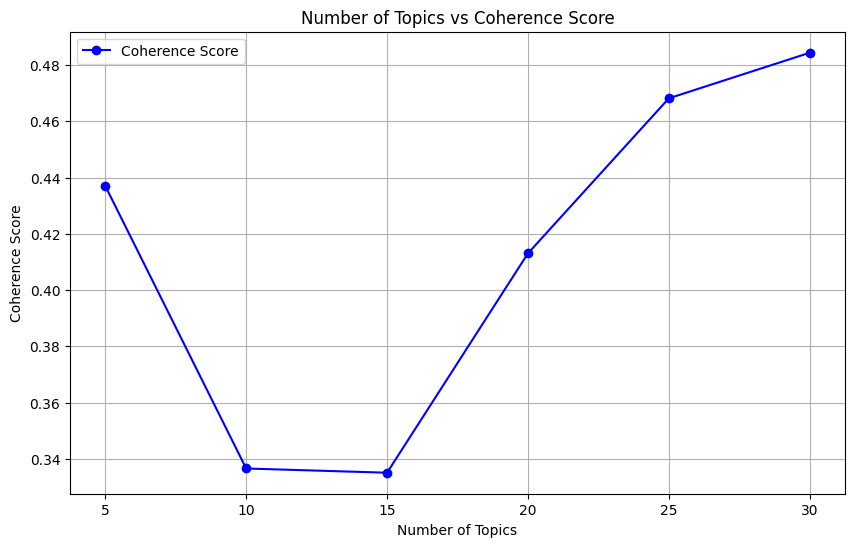

In [17]:
import matplotlib.pyplot as plt
# Specify the range of number of topics to search within
min_topics = 5
max_topics = 30
step_size = 5
topics_range = range(min_topics, max_topics+1, step_size)

# Perform Grid Search and compute coherence scores for different number of topics
coherence_scores = []
for num_topics in topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=dialogue['processed_text'], dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

# Find the optimal number of topics with the highest coherence score
optimal_num_topics = topics_range[np.argmax(coherence_scores)]
print("Optimal Number of Topics:", optimal_num_topics)
print("Coherence Score for Optimal Number of Topics:", max(coherence_scores))

# Plotting the relationship between the number of topics and coherence score
plt.figure(figsize=(10, 6))
plt.plot(topics_range, coherence_scores, marker='o', color='b', label='Coherence Score')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Number of Topics vs Coherence Score')
plt.xticks(topics_range)
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Number of topics for the LDA model
num_topics = 30

# Build the LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)

# Print the topics
pprint(lda_model.print_topics())

[(19,
  '0.451*"right" + 0.153*"still" + 0.146*"All" + 0.065*"hard" + 0.028*"cute" + '
  '0.017*"anyway" + 0.012*"fair" + 0.011*"nervously" + 0.009*"feet" + '
  '0.008*"dinosaur"'),
 (15,
  '0.378*"there" + 0.113*"name" + 0.079*"couch" + 0.058*"Then" + 0.050*"hair" '
  '+ 0.025*"clothes" + 0.022*"either" + 0.020*"pass" + 0.018*"comfortable" + '
  '0.016*"pocket"'),
 (24,
  '0.328*"little" + 0.104*"head" + 0.100*"else" + 0.058*"totally" + '
  '0.030*"floor" + 0.018*"wonderful" + 0.018*"breasts" + 0.016*"lucky" + '
  '0.016*"sometimes" + 0.016*"check"'),
 (4,
  '0.580*"just" + 0.108*"more" + 0.032*"over" + 0.027*"food" + 0.027*"umm" + '
  '0.025*"coffee" + 0.022*"true" + 0.021*"question" + 0.019*"plate" + '
  '0.009*"city"'),
 (2,
  '0.223*"room" + 0.171*"guy" + 0.109*"maybe" + 0.089*"only" + 0.043*"whole" + '
  '0.029*"alone" + 0.026*"outside" + 0.024*"week" + 0.020*"easy" + '
  '0.018*"times"'),
 (14,
  '0.237*"baby" + 0.082*"minute" + 0.076*"kind" + 0.054*"down" + 0.053*"as" + '
  '0.

In [18]:
# import the CoherenceModel class from the Gensim library
from gensim.models.coherencemodel import CoherenceModel

# compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, texts=dialogue['processed_text'], dictionary=id2word, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# print out result
print(f'Coherence Score: {coherence_score}')

Coherence Score: 0.4843817936683827


<ipython-input-24-79d06877fda9>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  axs[i].barh(words, word_freq, alpha=0.75, color=plt.cm.get_cmap('tab20')(i))


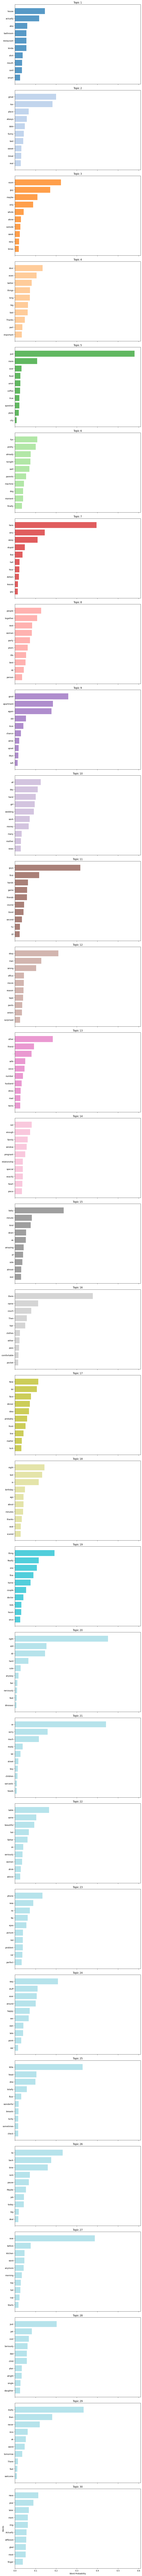

In [24]:
import matplotlib.pyplot as plt

# Define the number of top words to consider
n_top_words = 10

# Get the top words and their probabilities for each topic
topics = lda_model.get_topics()

# Plotting the bar graph for each topic
fig, axs = plt.subplots(num_topics, 1, figsize=(10, 6*num_topics), sharex=True)

for i, topic in enumerate(topics):
    top_indices = topic.argsort()[:-n_top_words-1:-1]
    words = [id2word[ind] for ind in top_indices]
    word_freq = [topic[ind] for ind in top_indices]
    axs[i].barh(words, word_freq, alpha=0.75, color=plt.cm.get_cmap('tab20')(i))
    axs[i].set_title(f'Topic {i+1}')
    axs[i].invert_yaxis()  # Invert y-axis to display the most frequent words on top

plt.xlabel('Word Probability')
plt.ylabel('Words')
plt.tight_layout()
plt.show()